# Chapter 14 금융 애플리케이션

In [16]:
!pip install yfinance

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import yfinance as yf

start_date = '1990-02-13'
end_date = '2019-02-13'

df = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [18]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000
1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000
1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000
1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000
1990-02-20,332.720001,332.720001,326.260010,327.989990,327.989990,147300000


In [19]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-06,2735.050049,2738.080078,2724.149902,2731.610107,2731.610107,3472690000
2019-02-07,2717.530029,2719.320068,2687.260010,2706.050049,2706.050049,4099490000
2019-02-08,2692.360107,2708.070068,2681.830078,2707.879883,2707.879883,3622330000
2019-02-11,2712.399902,2718.050049,2703.790039,2709.800049,2709.800049,3361970000
2019-02-12,2722.610107,2748.189941,2722.610107,2744.729980,2744.729980,3827770000


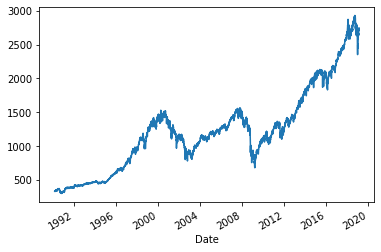

In [20]:
df.Close.plot()

약 30년 동안 1주일 단위로 조정된 종가 체크

([<matplotlib.axis.XTick at 0x7fc247c8d7d0>,
 [Text(0, 0, 'Mon'),
  Text(0, 0, 'Tue'),
  Text(0, 0, 'Wen'),
  Text(0, 0, 'Thu'),
  Text(0, 0, 'Fri')])

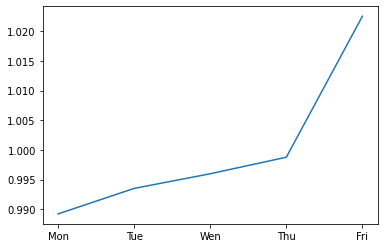

In [24]:
# 서로 다른 연도에서 한 주씩 총 3개를 선택
# 각 주의 평균 종가로 각 날의 종가를 조정
# 1990
vals = df['1990-05-07':'1990-05-11'].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels = ["Mon", "Tue", "Wen", "Thu", "Fri"])

([<matplotlib.axis.XTick at 0x7fc247d879d0>,
 [Text(0, 0, 'Mon'),
  Text(0, 0, 'Tue'),
  Text(0, 0, 'Wen'),
  Text(0, 0, 'Thu'),
  Text(0, 0, 'Fri')])

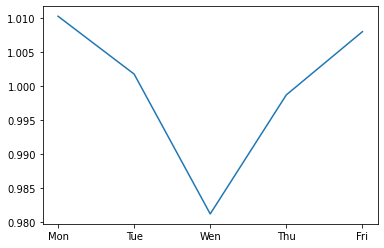

In [25]:
# 2000
vals = df['2000-05-08':'2000-05-12'].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels = ["Mon", "Tue", "Wen", "Thu", "Fri"])

([<matplotlib.axis.XTick at 0x7fc24378afd0>,
 [Text(0, 0, 'Mon'),
  Text(0, 0, 'Tue'),
  Text(0, 0, 'Wen'),
  Text(0, 0, 'Thu'),
  Text(0, 0, 'Fri')])

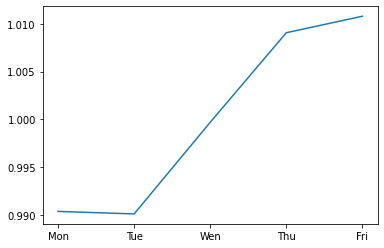

In [26]:
# 2018
vals = df['2018-05-07':'2018-05-11'].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels = ["Mon", "Tue", "Wen", "Thu", "Fri"])

상대적 비율은 각 연도마다 비슷해보임</br>
이러한 사실에 근거해 전체 시기를 통틀어서도 모델을 의미 있게 학습시키기에 충분히 유사하도록 만들 수 있는 방법을 알아보는것<br/>
즉, 금융적으로 의미가 있으면서도 전체 시기를 통해 호환 가능한 형태로 데이터를 변환할 방법을 알고 싶은 것

각 거래일의 시작가와 종가의 차이를 통해 수익 계산

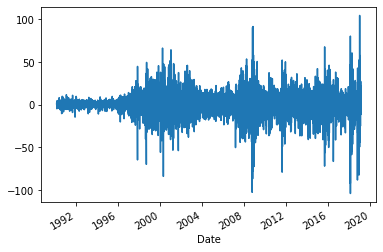

In [27]:
df['Return'] = df.Close - df.Open
df.Return.plot()

그래프를 봤을때 이 계산만으로 데이터가 호환 가능하도록 만들기에 충분치 않다는 것을 알 수 있음<br/>
모델의 입출력에 사용되는 값이 우리가 관심 있는 기간에 대해 더욱 균일해지도록 만들어줄 수 있음.

## 14.2 딥러닝을 위한 금융 데이터 전처리

### 전처리 과정
    1. 원시 입력에서 경제적으로 의미 있는 관심 양을 형성
    2. 사전관찰 없이 관심 양의 크기를 조절하기 위해서 관심 양에 대한 지수가중이동평균 및 분산을 계산
    3. 위의 두 단계 계산 결과를 묶어서 학습시킬 순환 딥러닝 모델에 적합한 형태로 만듬

### 14.2.1 원시 값에 관심 수량 추가

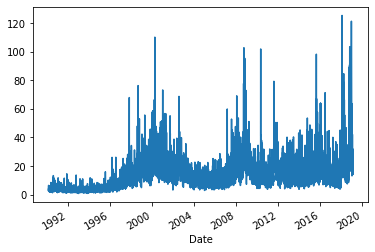

In [28]:
# 일일 수익
df['DailyVolatility'] = df.High - df.Low
df.DailyVolatility.plot()

### 14.2.2 사전관찰 없이 관심 수량 규모의 크기 조절
* 이전 일일 수익금
* 이전 일일 변동량
* 이전 일일 거래량<br/>
각각의 수량 규모 크기를 지수가중이동평균으로 뺀 다음 지수가중표준편차로 나누어 조정

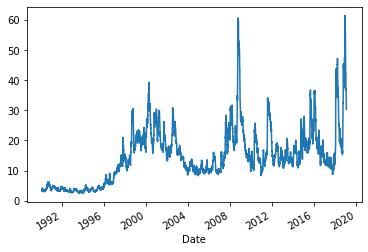

In [29]:
# halflife 파라미터 유의
ewdf = df.ewm(halflife = 10).mean()
ewdf.DailyVolatility.plot()

지수가중이동분산을 사용하여 시간에 따라 좀 더 일관적인 일련의 형태로 조정

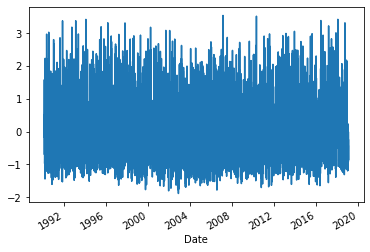

In [30]:
# 지수가중이동분산 계산
vewdf = df.ewm(halflife = 10).var()

# 평균을 빼고 정규화하여 크기를 조정
scaled = df.DailyVolatility - ewdf.DailyVolatility
scaled = scaled / vewdf.DailyVolatility ** 0.5
scaled.plot()

모든 원시 입력의 규모를 조정한 버전은 다음과 같음

In [31]:
df['ScaledVolatility'] = ((df.DailyVolatility - ewdf.DailyVolatility) / vewdf.DailyVolatility**0.5)
df['ScaledReturn'] = ((df.Return - ewdf.Return) / vewdf.Return**0.5)
df['ScaledVolume'] = ((df.Volume - ewdf.Volume) / vewdf.Volume**0.5)